# Project Part 1 - Common Analysis

**Author: Logan O'Brien**

Let's begin by importing the packages

In [1]:
import os, json, time
from pyproj import Transformer, Geod

#importing [4]
from wildfire.Reader import Reader as WFReader

import numpy as np
import requests
from tqdm import tqdm
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt #Source https://www.geeksforgeeks.org/line-chart-in-matplotlib-python/

## Step 1 Continued:

### Compare Smoke Estimate with EPA's AQI

At this point, we have created a smoke estimate and applied it to our wildfire data. Additionally, we have also retrieved some AQI data from sensor monitor sites close to Richland. Now, let's load those data compare them.

In [2]:
df_wildfire_data = pd.read_csv('./data/relevant_fires_and_smoke_est.csv')
df_wildfire_data

/tmp/ipykernel_735/3331033313.py:1: DtypeWarning: Columns (13,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_wildfire_data = pd.read_csv('./data/relevant_fires_and_smoke_est.csv')


,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,distance_to_richland,my_smoke_estimate
0,14299,14299,Wildfire,1963,1,"1 (1), 3 (3)",40992.458271,16589.059302,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,Prescribed fire data in this dataset represent...,NaN,NaN,0.385355,NaN,No,73550.428118,1.658906e+08,189.757596,33.753967
1,14300,14300,Wildfire,1963,1,"1 (1), 3 (3)",25757.090203,10423.524591,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,Prescribed fire data in this dataset represent...,NaN,NaN,0.364815,NaN,No,59920.576713,1.042352e+08,163.213533,24.658160
2,14301,14301,Wildfire,1963,1,"1 (5), 3 (15), 5 (1)",45527.210986,18424.208617,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (6), Likely Wildfire (15)",...,Prescribed fire data in this dataset represent...,NaN,NaN,0.320927,NaN,No,84936.827810,1.842421e+08,190.823448,37.278578
3,14302,14302,Wildfire,1963,1,"1 (1), 3 (3), 5 (1)",10395.010334,4206.711433,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (3)",...,Prescribed fire data in this dataset represent...,NaN,NaN,0.428936,NaN,No,35105.903602,4.206711e+07,273.615572,5.936140
4,14303,14303,Wildfire,1963,1,"1 (1), 3 (3)",9983.605738,4040.221900,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,Prescribed fire data in this dataset represent...,NaN,NaN,0.703178,NaN,No,26870.456126,4.040222e+07,205.770574,7.580960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76402,135057,135057,Prescribed Fire,2020,8,8 (3),16.412148,6.641761,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (3),...,Prescribed fire data in this dataset represent...,NaN,"Caution, this Prescribed Fire in 2020 overlaps...",0.177425,NaN,No,2168.900740,6.641761e+04,248.914999,NaN
76403,135058,135058,Prescribed Fire,2020,8,8 (1),7.050837,2.853373,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (1),...,Prescribed fire data in this dataset represent...,NaN,"Caution, this Prescribed Fire in 2020 overlaps...",0.374368,NaN,No,978.666221,2.853373e+04,167.983467,NaN
76404,135059,135059,Prescribed Fire,2020,8,8 (4),9.342668,3.780843,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (4),...,Prescribed fire data in this dataset represent...,NaN,"Caution, this Prescribed Fire in 2020 overlaps...",0.123888,NaN,No,1958.326660,3.780843e+04,168.822089,NaN
76405,135060,135060,Prescribed Fire,2020,8,8 (1),0.996962,0.403456,Comb_National_Rx_Only_BLM_VTRT_Prescribed_Fire...,Prescribed Fire (1),...,Prescribed fire data in this dataset represent...,NaN,NaN,0.993809,1.0,No,225.866452,4.034562e+03,655.423767,NaN


In [3]:
df_annual_aqi = pd.read_csv('./data/Annual_AQI_Average.csv')
df_annual_aqi

,Unnamed: 0,Year,AQI
0,0,1985,NaN
1,1,1986,NaN
2,2,1987,NaN
3,3,1988,NaN
4,4,1989,NaN
5,5,1990,NaN
6,6,1991,1258.000000
7,7,1992,303.500000
8,8,1993,1062.000000
9,9,1994,NaN


Now, before we compare the two, let's get an annual measure of my wildire smoke estimate.

In [4]:
# I viewed: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html
# and: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html#
# to remind myself how to do a groupby
df_annual_smoke_est = df_wildfire_data[['Fire_Year', 'my_smoke_estimate']]
df_annual_smoke_est = df_annual_smoke_est.groupby('Fire_Year', as_index=False).agg('mean')
df_annual_smoke_est

,Fire_Year,my_smoke_estimate
0,1963,7.005706
1,1964,3.847053
2,1965,5.693719
3,1966,6.604428
4,1967,6.361571
5,1968,4.996357
6,1969,3.278161
7,1970,10.069566
8,1971,8.621687
9,1972,3.740738


**Comparison:** Now, comparing my smoke estimate with the AQI values I retrieved, we notice a couple of differences quite quickly. First, I only retrieved AQI data back to 2001, while my smoke estimate is available from 1963 to 2020. Additionally, the magitude of the AQI is larger than my smoke estimate. Later in step 2, we will see a graph visualizing a time series of these two metrics.

### Predictive Model

Before we run a prediction, we need to do some aggregation to transform the wildfire data above into a form where there is a single row for each year. Note, I am assuming that the 'GIS_Acres' field represents the acreas burned in the corresponding fire.

In [5]:
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html
# Reference: https://stackoverflow.com/questions/32059397/pandas-groupby-without-turning-grouped-by-column-into-index
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html#
df_wildfire_data_annual = df_wildfire_data.groupby('Fire_Year', as_index=False).agg(
            fire_count = pd.NamedAgg(column='OBJECTID', aggfunc='count'),
            total_acres_burned = pd.NamedAgg(column='GIS_Acres', aggfunc='sum'),
            avg_distance_to_richland = pd.NamedAgg(column='distance_to_richland', aggfunc='mean'),
            annual_smoke_estimate = pd.NamedAgg(column='my_smoke_estimate', aggfunc='mean')
)
df_wildfire_data_annual.head()

,Fire_Year,fire_count,total_acres_burned,avg_distance_to_richland,annual_smoke_estimate
0,1963,356,247045.892312,552.514066,7.005706
1,1964,358,441023.155218,545.260237,3.847053
2,1965,317,238800.072577,505.889084,5.693719
3,1966,409,696737.289350,548.726794,6.604428
4,1967,421,481780.538909,561.889122,6.361571


Although the assignment instructions ask me to develop a prediction model on the fire data and smoke estimates, it is not possible to include fire data in the training data because we will be predicting smoke estimates for the future, where we will not know how many fires occur, acreage burned, distance from Richland, etc. Thus, I will use the only thing we will know - namely the year.

Now we are ready to perform a simple prediction for the next 25 years (i.e. from 2024-2049). Let's use linear regression. Note, I consulted the following resources to help me and I reused or modified code from them:
- https://stackoverflow.com/questions/29623171/simple-prediction-using-linear-regression-with-python
- https://www.geeksforgeeks.org/python-create-list-of-numbers-with-given-range/#

In [6]:
from sklearn.linear_model import LinearRegression

#get your training data
X = list(df_wildfire_data_annual['Fire_Year'])

#reference: https://stackoverflow.com/questions/68429511/attributeerror-list-object-has-no-attribute-reshape-when-using-reshape-for
X = np.array(X)
X = np.reshape(X, (-1, 1))

Y = df_wildfire_data_annual['annual_smoke_estimate']

# now we model
model = LinearRegression()
model.fit(X,Y)

# perform prediction
X_preds = list(range(2024, 2049 + 1))

#reference: #reference: https://stackoverflow.com/questions/68429511/attributeerror-list-object-has-no-attribute-reshape-when-using-reshape-for
X_preds = np.array(X_preds)
X_preds = np.reshape(X_preds, (-1, 1))

Y_preds = model.predict(X_preds)
smoke_predictions = list(Y_preds)

# store data in dataframe
dates = list(range(2024, 2049 + 1))

df_smoke_predictions = pd.DataFrame({
    'year' : dates,
    'smoke_prediction' : smoke_predictions
})

df_smoke_predictions

,year,smoke_prediction
0,2024,10.953371
1,2025,11.057817
2,2026,11.162263
3,2027,11.266709
4,2028,11.371156
5,2029,11.475602
6,2030,11.580048
7,2031,11.684494
8,2032,11.788940
9,2033,11.893387


As you can see by instpecting the dataframe above, the linear regression model predicts a steady increase in the smoke estimate. However, this prediction should be taken with caution. Due to the time constraints I was under for this assignment, I did not address or validate any assumptions underlying this model. Additionally, I made several assumptions and aribtrary choices throughout the data gathering steps of this assignment. Under conditions where I would have more time, I would select a model more carefully and more thoroughly evaluate and defend the assumptions and arbitrary steps that I took in this assignment.

## Step 2: Visualize Aspects of Your Analysis

According to the assignment instructions, the next step is to visulize aspects of my analysis according to three specifications quoted below:
- 1.	Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.
- 2.	Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.
- 3.	Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.


I consulted several references to remind myself how to use plotting features in Python. In some cases I reused or modified and resused code snippets. Here is the list:
- My Jupyter Notebook from HW1 'DATA 512 Homework 1 Acquire Process and Analyze Data.ipynb'

1. **Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.**

I am assuming that when the prompt says "max specified distance" it is referring to 1250 miles, which was given in the assignment instructions. Now, let's plot the data. 

Note, I referrenced the following source to learn how to create a histogram and resused some of the code:https://www.geeksforgeeks.org/plotting-histogram-in-python-using-matplotlib/

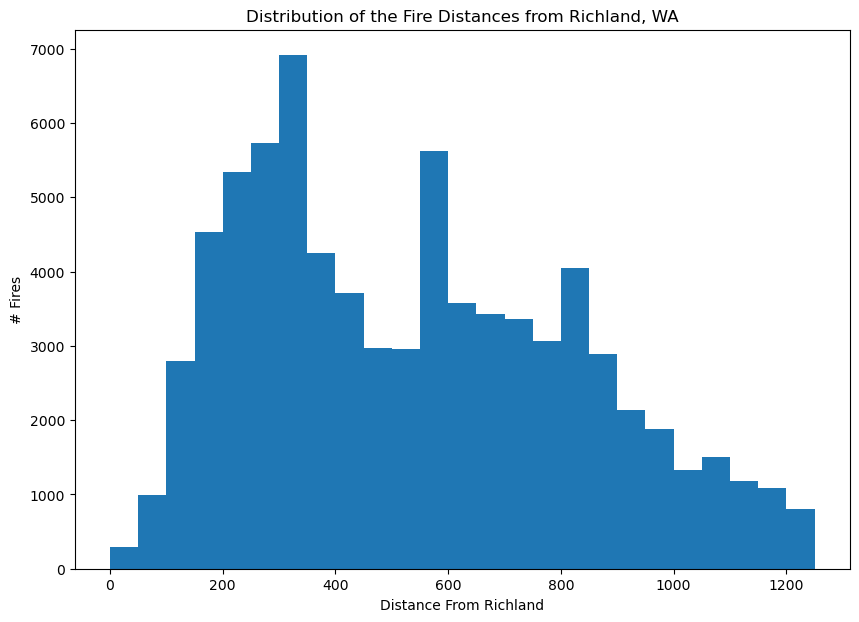

In [7]:
# get distances
dist = df_wildfire_data['distance_to_richland']

# Create the histogram
fig, ax = plt.subplots(figsize = (10, 7))
ax.hist(dist, bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900,
                     950, 1000, 1050, 1100, 1150, 1200, 1250])

# # Add legend
# plt.legend()

plt.xlabel("Distance From Richland")
plt.ylabel("# Fires")
plt.title("Distribution of the Fire Distances from Richland, WA")

plt.show()

2. **Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.**

I am assuming that when the prompt says "specified distance" it is referring to 1250 miles, which was given in the assignment instructions. Recall that in another notebook I filtered the wildfire data to only consider fires within this distance from Richland, so the distance requirement is satisfied. Now, let's plot the data. 

I viewed this reference in the process: https://www.geeksforgeeks.org/how-to-plot-logarithmic-axes-in-matplotlib/#

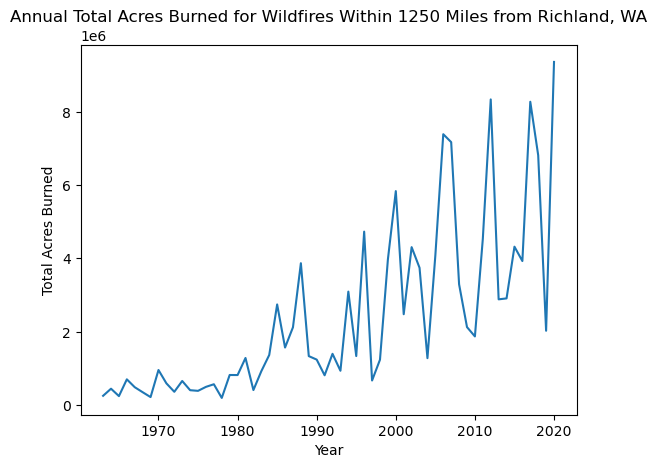

In [8]:
# start with smoke estimate
x = df_wildfire_data_annual['Fire_Year']
y = df_wildfire_data_annual['total_acres_burned']
plt.plot(x, y)

plt.xlabel("Year")
plt.ylabel("Total Acres Burned")
plt.title("Annual Total Acres Burned for Wildfires Within 1250 Miles from Richland, WA")

plt.show()

To be honest, I am not sure what scale I should use for this plot, so I will leave it as the default.

3. **Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.**

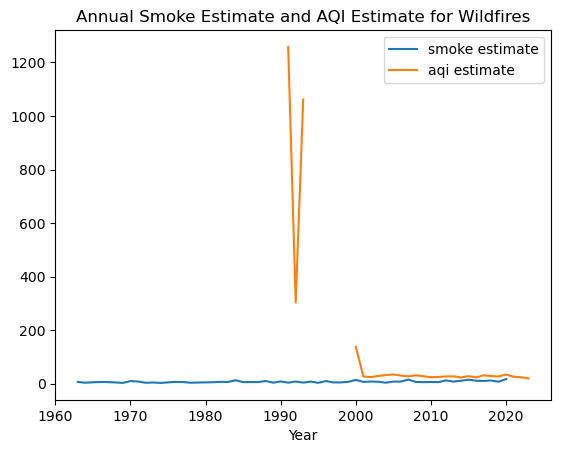

In [9]:
# start with smoke estimate
x = df_annual_smoke_est['Fire_Year']
y = df_annual_smoke_est['my_smoke_estimate']
plt.plot(x, y, label = "smoke estimate")

# aqi estimate
x1 = df_annual_aqi['Year']
y1 = df_annual_aqi['AQI']
plt.plot(x1, y1, label = 'aqi estimate')

# Add legend
plt.legend()

plt.xlabel("Year")
# plt.ylabel("# Monthly Views")
plt.title("Annual Smoke Estimate and AQI Estimate for Wildfires")

plt.show()

Looking at the chart the two metrics seem to behave quite similarly. Let's check if they are correlated.

Let's examine these outliers

In [10]:
df_annual_aqi

,Unnamed: 0,Year,AQI
0,0,1985,NaN
1,1,1986,NaN
2,2,1987,NaN
3,3,1988,NaN
4,4,1989,NaN
5,5,1990,NaN
6,6,1991,1258.000000
7,7,1992,303.500000
8,8,1993,1062.000000
9,9,1994,NaN


By inspection, we see that the years from 1985 through 1999 are mostly empty, aside from 3 large values of AQI. In fact, if my memory serves me correctly, AQI can only go up to 500, implying that those values are erroneous. Let's drop everything prior to the year 2001 and plot the line chart again.

In [14]:
df_annual_aqi = df_annual_aqi[df_annual_aqi['Year'] > 2000]

# referenced: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
df_annual_aqi = df_annual_aqi.reset_index(drop = True)
df_annual_aqi

,Unnamed: 0,Year,AQI
0,16,2001,27.142157
1,17,2002,25.405063
2,18,2003,29.024390
3,19,2004,32.616162
4,20,2005,34.889764
5,21,2006,30.577778
6,22,2007,27.794521
7,23,2008,31.778689
8,24,2009,28.121547
9,25,2010,24.295890


Now, let's reduce the smoke estimate data to the same years (2001 to present).

In [16]:
df_smoke_reduced = df_annual_smoke_est[df_annual_smoke_est['Fire_Year'] > 2000]

# referenced: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
df_smoke_reduced = df_smoke_reduced.reset_index(drop = True)
df_smoke_reduced

,Fire_Year,my_smoke_estimate
0,2001,7.053629
1,2002,8.390895
2,2003,7.586206
3,2004,4.137213
4,2005,8.052111
5,2006,8.243027
6,2007,15.818612
7,2008,6.757800
8,2009,6.209317
9,2010,6.639404


Plotting the data

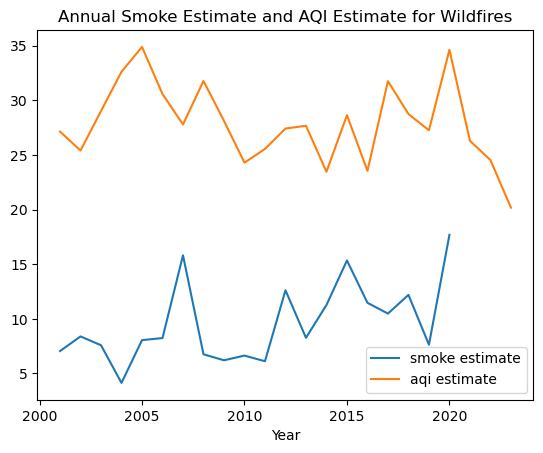

In [17]:
# start with smoke estimate
x = df_smoke_reduced['Fire_Year']
y = df_smoke_reduced['my_smoke_estimate']
plt.plot(x, y, label = "smoke estimate")

# aqi estimate
x1 = df_annual_aqi['Year']
y1 = df_annual_aqi['AQI']
plt.plot(x1, y1, label = 'aqi estimate')

# Add legend
plt.legend()

plt.xlabel("Year")
# plt.ylabel("# Monthly Views")
plt.title("Annual Smoke Estimate and AQI Estimate for Wildfires")

plt.show()

In [18]:
# calculate the correlation
# I learned how to do this from: https://pandas.pydata.org/docs/reference/api/pandas.Series.corr.html
y.corr(y1)

0.07678411466213339

Numerically, there is a weak positive correlation between the smoke and aqi estimates.

## References:
- Learning to use .gitignore:
    * https://stackoverflow.com/questions/19663093/apply-gitignore-on-an-existing-repository-already-tracking-large-number-of-file
    * https://stackoverflow.com/questions/40441450/relative-parent-directory-path-for-gitignore
- Learning to work with GIS data:
    * [3] wildfire_geo_proximity_example.ipynb. //"This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.0 - August 13, 2023"
- [4]. Proffessor's wildfire module
- [5]. https://www.latlong.net/place/west-richland-wa-usa-25340.html
- [6]. https://stackoverflow.com/questions/12268930/create-json-with-multiple-dictionaries-python
- [7]. https://www.geeksforgeeks.org/reading-and-writing-json-to-a-file-in-python/#
- [8]. https://www.w3schools.com/python/python_try_except.asp
- [9]. 'DATA 512 Homework 1 Acquire Process and Analyze Data.ipynb' at: https://github.com/logan-obrien/data-512-homework_1.git
- [10]. https://www.airnow.gov/aqi/aqi-basics/
- [11]. https://www.google.com/search?q=how+to+convert+acres+to+square+miles&rlz=1C1RXQR_enUS1019US1019&oq=how+to+convert+from+acres+to+s&gs_lcrp=EgZjaHJvbWUqCAgDEAAYFhgeMgYIABBFGDkyCAgBEAAYFhgeMggIAhAAGBYYHjIICAMQABgWGB4yCAgEEAAYFhgeMgoIBRAAGIYDGIoFMgoIBhAAGIYDGIoF0gEIOTU3MmowajeoAgCwAgA&sourceid=chrome&ie=UTF-8
- [12]. https://www.geeksforgeeks.org/numpy-argmax-python/
- [13]. https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
- [14]. epa_air_quality_history_example.ipynb //"This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - September 5, 2023"
- [15]. https://www.census.gov/library/reference/code-lists/ansi.html#cousub 
- [16]. https://www2.census.gov/geo/docs/reference/codes2020/cousub/st53_wa_cousub2020.txt
- [17]. https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf
- [18]. https://www.epa.gov/wildfire-smoke-course/why-wildfire-smoke-health-concern

## Personal Notes:

**Python Tricks/Notes to Memorize:**
- range() function does not include upper bound so have to add 1.
- a lot of coding is doing the same sorts of operations or data manipulations over and over. Learn the best most efficient ways to do them. e.g. iterating over a list of days between two dates.

In [ ]:
# # Reference: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html
# # Reference: https://stackoverflow.com/questions/32059397/pandas-groupby-without-turning-grouped-by-column-into-index
# # Reference: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.aggregate.html#
# df_wildfire_data_annual = df_wildfire_data.groupby('Fire_Year', as_index=False).agg(
#             fire_count = pd.NamedAgg(column='OBJECTID', aggfunc='count'),
#             avg_acres_burned = pd.NamedAgg(column='GIS_Acres', aggfunc='mean'),
#             avg_distance_to_richland = pd.NamedAgg(column='distance_to_richland', aggfunc='mean'),
#             annual_smoke_estimate = pd.NamedAgg(column='my_smoke_estimate', aggfunc='mean')
# )
# df_wildfire_data_annual.head()